## Image segmentation with CamVid

We're gonna treat images as pixels, and try to classify every single pixel into a category, obtaining a color mask for the picture. That's image segmentation.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [0]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/0006R0_f02640.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_008880.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f03480.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0001TP_009780_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_01560_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f00480_P.png')]

We take a look at one image, in its original state:

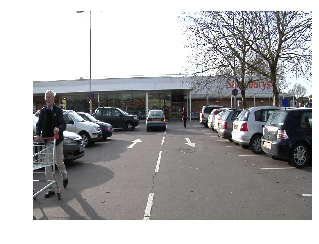

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

A function to translate from an image path to its mask path:

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

And this is the segmentation mask:

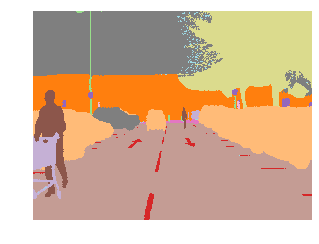

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ..., 26, 26, 26],
          [21, 21, 21,  ..., 26, 26, 26],
          [21, 21, 21,  ..., 26, 26, 26],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [13]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 15068MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

If we flip images in the transformations set, we also need to flip masks; that's only an example; we need to apply the same transformations we do to the images to the masks, using `tfm_y=True`.

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

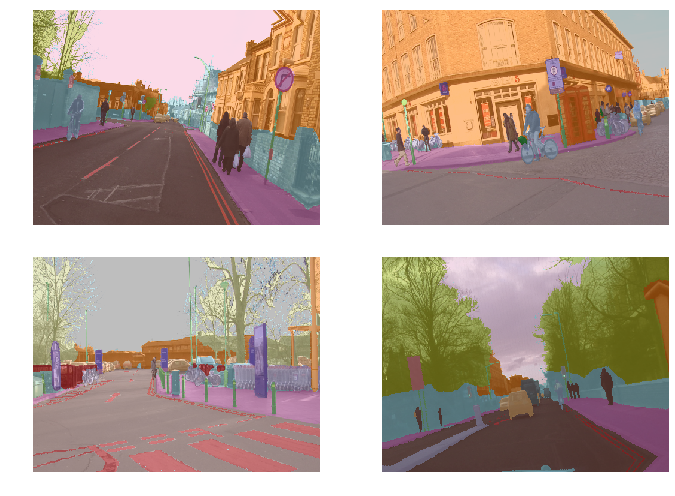

In [16]:
data.show_batch(2, figsize=(10,7))

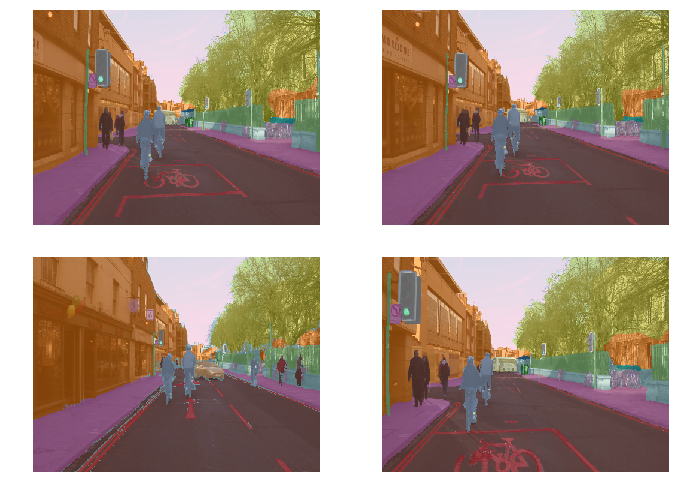

In [17]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

We use a custom metric, because we need to avoid the 'Void' pixels when reporting accuracy for the CamVid dataset.

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):    # input is the output of the network
    target = target.squeeze(1)
    mask = target != void_code    # the interesting part
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
# metrics=accuracy

In [0]:
wd=1e-2

For segmentation we use **U-Net** instead of cnn, because it works better.

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


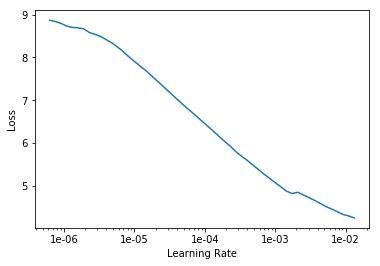

In [22]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=3e-3

In [24]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.547495,1.056105,0.767161,01:41
1,0.988584,0.719101,0.823675,01:36
2,0.748034,0.577895,0.851183,01:36
3,0.678417,0.529974,0.864448,01:36
4,0.629186,0.546214,0.867787,01:36
5,0.602870,0.500236,0.858887,01:36
6,0.599059,0.494200,0.873120,01:35
7,0.584512,0.482592,0.863020,01:35
8,0.550355,0.442941,0.872488,01:35
9,0.477397,0.355623,0.897222,01:35


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

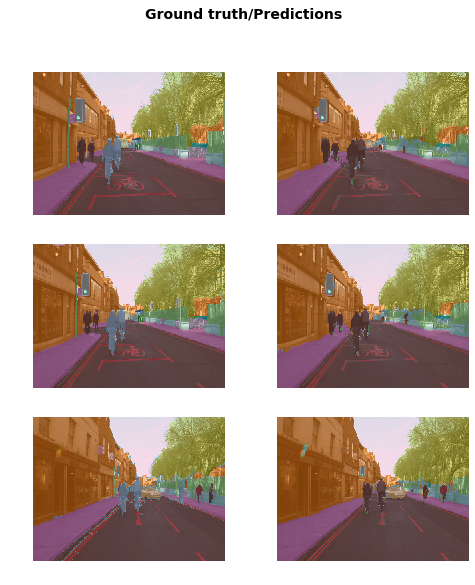

In [27]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

We plot LR Finder:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


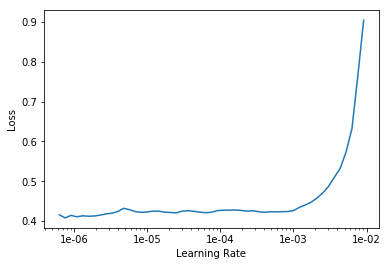

In [29]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lrs = slice(lr/400,lr/4)

In [31]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.406521,0.328985,0.901846,01:38
1,0.393605,0.326661,0.905132,01:38
2,0.380372,0.299025,0.917515,01:38
3,0.372735,0.310188,0.915023,01:38
4,0.362719,0.320804,0.905871,01:38
5,0.349679,0.284280,0.921278,01:38
6,0.339822,0.315022,0.911313,01:38
7,0.333855,0.306032,0.910245,01:38
8,0.323225,0.286050,0.921349,01:38
9,0.316596,0.290519,0.914192,01:38


We plot training and validation loss: 

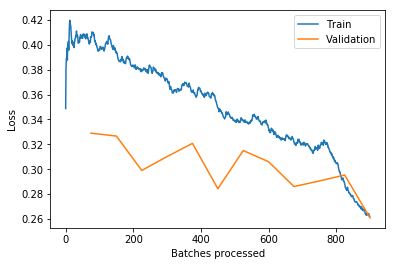

In [32]:
learn.recorder.plot_losses()

We see that quite often **losses go up a bit before they go down** (and if not, you'd want to increase the LR). This is normal, because the LR first increases until a maximum, before it goes down (that's the maximum we pass into 1 fit cycle). That's a recent improvement over typical *learning rate annealing*, when LR starts at the highest value and it goes down when approximating to the minimum. This "triangular" LR approach explores most of the loss function surface, so it's more probable that it achieves the global minimum.

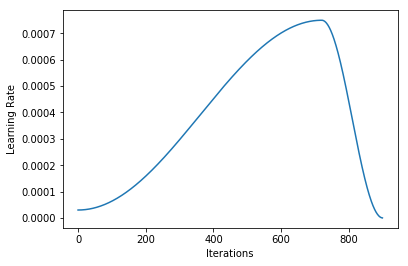

In [33]:
learn.recorder.plot_lr()

In [0]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [35]:
#learn.destroy() # uncomment once 1.0.46 is out

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=3, have 12517MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


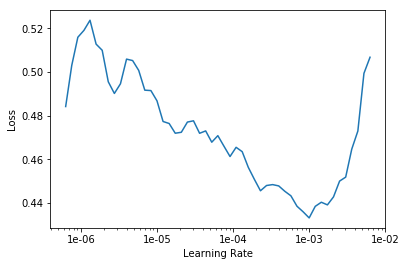

In [39]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [41]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.372462,0.324485,0.908394,06:30
1,0.347098,0.309147,0.908819,06:26
2,0.344443,0.311451,0.909620,06:26
3,0.342886,0.294680,0.919670,06:26
4,0.329384,0.329477,0.907755,06:26
5,0.333892,0.323710,0.909027,06:25
6,0.345421,0.394464,0.893276,06:24
7,0.322516,0.304631,0.920370,06:23
8,0.271084,0.253645,0.931011,06:23
9,0.234459,0.247457,0.931906,06:24


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [46]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.228942,0.241246,0.933957,06:37
1,0.220382,0.237851,0.935524,06:36
2,0.219953,0.240423,0.934950,06:37
3,0.215187,0.248613,0.931498,06:37
4,0.212376,0.236138,0.936662,06:37
5,0.211379,0.243290,0.934306,06:37
6,0.199179,0.237745,0.937076,06:37
7,0.188387,0.245873,0.935257,06:38
8,0.193847,0.245387,0.935142,06:37
9,0.197271,0.241070,0.936036,06:38


In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

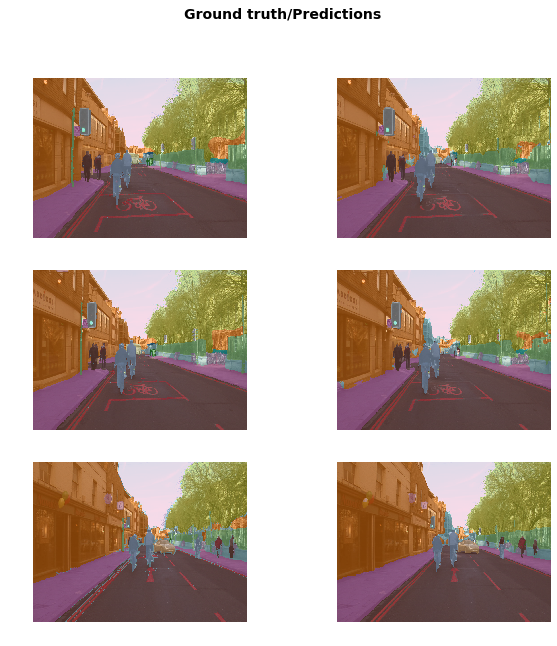

In [49]:
learn.show_results(rows=3, figsize=(10,10))